## Goal: predict if credit card transaction should be categorized as Fraud

Year over year digital payments are on rise with the increase in online shopping which means we don’t have to have a physical card to complete the transactions. A large percentage of digital payment is done using credit cards. This brings a challenge where anyone having the details of the card can make transactions using others card and owner of the card gets to know only after transaction is completed. Credit card fraud is associated with scenario where owner of the credit card account did not authorize to use the credit card for making purchases. As per the Federal Trade Commission report 2021, credit card fraud loses in 2020 added up to $149 million. 

Credit card fraud is on rise every year and identifying potential fraudulent credit card transaction is a big challenge where card issuers have developed system to monitor transactions and flag fraudulent transactions and hence we do see sometimes our real transactions are getting denied at the first instance and then banks send notification for confirmation if a transaction is recognized by credit card owner and if yes, then bank asks us to retry the transaction. The solution to identify the potential fraudulent transaction is continuing to evolve. Credit card companies are leveraging various machine learning methods and no solution is perfect in identifying the credit card fraudulent transaction as we continue to see credit card fraud is going up every year.


# This section is to perform data aquisition and EDA (Exploratory data analysis)

Data has been downloaded from https://www.kaggle.com/competitions/ieee-fraud-detection/data 

I will be using below 2 datasets for my project:

train_transaction.csv

train_identity.csv

train_transaction.csv data file contains details of the transaction and “isFraud” represents the target variable for our use case :

o	TransactionID: Unique id for the transaction

o	isFraud: Flag which shows if a transaction is Fraud or not (0,1)

o	TransactionDT: timedelta from a given reference datetime

o	TransactionAMT: transaction payment amount in USD

o	ProductCD: product code, the product for each transaction

o	card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

o	addr: address

o	dist: distance

o	P_ and (R__) emaildomain: purchaser and recipient email domain

o	C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

o	D1-D15: timedelta, such as days between previous transaction, etc.

o	M1-M9: match, such as names on card and address, etc.

o	Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Train_identity.csv data file contains details of the person making the transaction:

o	TransactionID: Unique id for the transaction

o	Id1-Id38: identity info collected

o	DeviceType: Type of device used for making the transaction

o	DeviceInfo: Details of device used for making the transaction

These 2 datasets will be joined on TransactionID field.

I have saved these 2 data files on my local machine and performing all analysis in this section

In [42]:
# perform import for the packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,auc,roc_auc_score,average_precision_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score,precision_recall_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

import itertools 
import joblib
from joblib import dump,load

from sklearn.impute import KNNImputer
from sklearn import metrics, set_config, tree
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import keras
from keras import layers
from keras.models import load_model

#import Grid Search CV to find the parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [12]:
# Set pandas output display option when needed during exploration to see all records in output

pd.set_option('display.max_rows', None)

In [14]:
# Set pandas output display option when needed during exploration to see all fields in output

pd.set_option('display.max_columns', None)

In [2]:
# Set pandas output display option to lower level when exploration is done
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)

In [80]:
import warnings
warnings.filterwarnings('ignore')

In [348]:
# To display default parameters for different classifiers

set_config(print_changed_only=False)

In [65]:
%%time 
# Read source credit card transaction dataset
source_card_transactions=pd.read_csv(r'C:\Users\pujak\Downloads\train_transaction.csv')

print('source card transactions data set has been loaded successfully.')

source card transactions data set has been loaded successfully.
Wall time: 26.9 s


In [66]:
%%time 
# Read source credit card transaction dataset
source_identity=pd.read_csv(r'C:\Users\pujak\Downloads\train_identity.csv')

print('source identity data set has been loaded successfully.')

source identity data set has been loaded successfully.
Wall time: 934 ms


In [4]:
# Display top 5 recods from the Credit card transaction dataset

source_card_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Display bottom 5 recods from the Credit card transaction dataset

source_card_transactions.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Display top 5 recods from the Credit card identity dataset

source_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
source_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [8]:
source_card_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [67]:
%%time 

source_card_transactions_with_identity=source_card_transactions.merge(source_identity, how="left", on="TransactionID")

print('Source Final Dataset',source_card_transactions_with_identity.shape)

print("Source Data set merged into one ")

Source Final Dataset (590540, 434)
Source Data set merged into one 
Wall time: 20.7 s


In [11]:
# deleting the dataframe after processing and creating another data frame for further exploration and processing
del source_card_transactions
del source_identity

In [10]:
# Display top 5 records from source

source_card_transactions_with_identity.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [68]:
# Generating correlation matrix for all features from the source. Since there are large # of features in dataset hence
# it is difficult to review and determine which features to be eliminated and hence I have decided to perform PCA
# (Principal component analysis) on the dataset to keep only relevant features for prediction

source_card_transactions_with_identity.corr()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
TransactionID,1.000000,0.014166,0.998280,0.012025,0.010122,-0.019900,-0.010091,-0.023900,-0.000370,0.057213,-0.027043,-0.026273,-0.053154,-0.055186,-0.008896,-0.057235,0.024444,-0.050376,-0.059485,-0.060490,0.033460,-0.062073,-0.054122,-0.058796,-0.017455,-0.043123,0.074338,0.026477,-0.006997,0.058633,0.002053,0.081941,-0.071569,-0.071505,-0.015457,0.056533,0.100242,0.052536,0.023352,0.095742,0.071285,0.001609,0.043721,0.044101,0.036061,0.033277,0.037936,0.037899,0.036606,0.035126,0.012900,0.015073,0.095513,0.093682,-0.003049,-0.027305,-0.030358,-0.018493,-0.020758,0.012811,0.004417,-0.018802,-0.017885,-0.001733,-0.001529,0.008267,0.001800,-0.006796,-0.004716,0.013342,0.014974,-0.030654,-0.033514,-0.011654,0.001312,0.122415,0.119793,-0.011573,-0.003462,-0.054059,-0.045949,-0.001940,-0.060570,-0.050184,-0.006123,-0.003488,-0.022559,-0.020398,0.033435,0.033073,-0.073398,-0.035869,-0.025255,0.109545,0.106413,0.005278,0.021741,-0.039267,-0.031172,-0.022812,-0.015934,0.015731,0.014385,-0.023153,-0.012838,-0.003834,0.005375,0.006396,-0.003225,0.014323,0.015880,-0.035108,-0.027716,-0.022403,-0.007149,0.101272,0.098428,-0.002823,0.017021,-0.029226,-4.314124e-02,-0.033431,0.009284,0.008316,-0.045756,-0.028955,-0.000726,0.003122,-2.152710e-03,-0.004515,0.022317,0.022916,-0.054259,-0.044316,-0.024978,0.059641,0.066849,0.067562,0.018179,0.075549,0.064023,0.058758,0.062462,0.065413,0.061837,0.071223,0.071692,-0.022165,0.004815,0.030843,0.015882,-0.005594,0.008128,-0.001196,0.014165,0.051740,0.028589,-0.011014,0.006492,-0.005405,-0.007017,0.019939,0.004401,0.009696,0.058098,0.038253,0.058853,0.066398,0.066591,0.004234,0.067183,0.041028,0.058108,0.061456,0.064225,0.019901,0.058545,0.044327,-0.007022,0.038760,0.044782,0.022475,0.037229,0.157087,-0.248605,-0.273548,0.061851,0.059484,0.042271,0.042437,-0.306317,-0.303988,-0.237093,0.039431,0.041361,0.041873,0.041688,0.050565,0.051548,-0.302742,-0.282572,-0.014603,0.003533,-0.010569,0.167661,0.064338,-0.154957,0.135566,0.146449,0.016365,0.039247,0.137835,-0.023858,-0.012754,0.090709,0.163273,0.018667,0.134468,

In [349]:
#list(source_card_transactions_with_identity.columns)

In [13]:
source_card_transactions_with_identity.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 434, dtype: object

In [350]:
categorical_fields = source_card_transactions_with_identity.select_dtypes(include=object).columns.tolist()
#categorical_fields

In [351]:
numerical_fields = source_card_transactions_with_identity.select_dtypes(exclude=object).columns.tolist()
#numerical_fields

In [16]:
# Distribution of null counts in categorical features

source_card_transactions_with_identity[categorical_fields].isna().sum()

ProductCD             0
card4              1577
card6              1571
P_emaildomain     94456
R_emaildomain    453249
M1               271100
M2               271100
M3               271100
M4               281444
M5               350482
M6               169360
M7               346265
M8               346252
M9               346252
id_12            446307
id_15            449555
id_16            461200
id_23            585371
id_27            585371
id_28            449562
id_29            449562
id_30            512975
id_31            450258
id_33            517251
id_34            512735
id_35            449555
id_36            449555
id_37            449555
id_38            449555
DeviceType       449730
DeviceInfo       471874
dtype: int64

In [17]:
# Distribution of null counts in numerical features

source_card_transactions_with_identity[numerical_fields].isna().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
card1                  0
                   ...  
id_22             585371
id_24             585793
id_25             585408
id_26             585377
id_32             512954
Length: 403, dtype: int64

<AxesSubplot:>

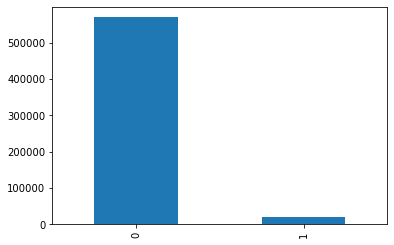

In [71]:
# Create Bar Chart to show distribution of fraud and real transactions

source_card_transactions['isFraud'].value_counts().sort_values(ascending=False).plot(kind = 'bar')

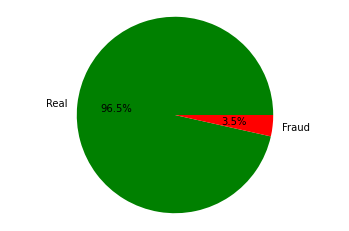

In [72]:
# Create Pie chart to show percentage distribution of fraud and real transactions 

# Check IsFraud variables that has 0 value for Real transactions and 1 for Fraud transactions

fig, ax = plt.subplots(1, 1)

ax.pie(source_card_transactions.isFraud.value_counts(),autopct='%1.1f%%', labels=['Real','Fraud'], colors=['green','r'])

plt.axis('equal')
plt.ylabel('')

plt.show()

Above distribution of transactions shows that % of Fraud transactions are very small compare to Real transactions which is what
we would expect in reality. I will be performing oversampling to this dataset later so that when using Logistic regession and DNN model then model should result in better performance.

590535    24.0
590536    24.0
590537    24.0
590538    24.0
590539    24.0
Name: TransactionDT_Hour, dtype: float64


Text(0, 0.5, '# Transactions')

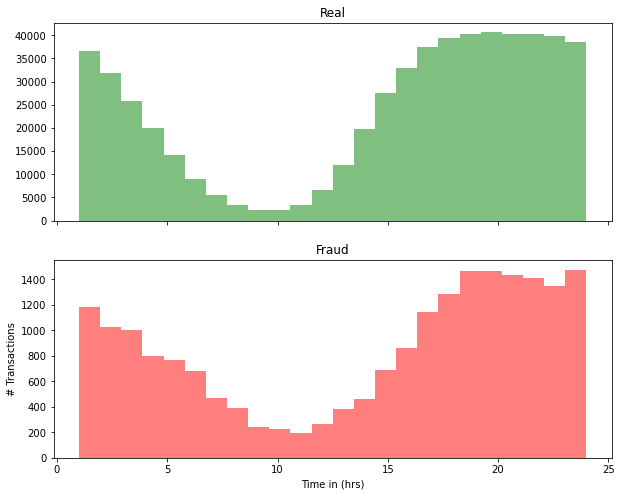

In [73]:
# Distribution of transactions based on time of the day. I want to see if particular hour of the day has any strong 
# correlation with transactipn type Real vs Fraud

source_card_transactions["TransactionDT_Hour"]= source_card_transactions["TransactionDT"]/3600%24 # convert to hours
source_card_transactions["TransactionDT_Hour"]= source_card_transactions["TransactionDT_Hour"].apply(np.ceil)
source_card_transactions["TransactionDT_Hour"]= source_card_transactions["TransactionDT_Hour"].replace(0.0,24.0)
print(source_card_transactions["TransactionDT_Hour"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,8))
ax1.hist(source_card_transactions.TransactionDT_Hour[source_card_transactions.isFraud==0],bins=24,color='g',alpha=0.5)
ax1.set_title('Real')
ax2.hist(source_card_transactions.TransactionDT_Hour[source_card_transactions.isFraud==1],bins=24,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time in (hrs)')
plt.ylabel('# Transactions')

Above plot shows that there is not specific hour of the day when Fraud transactions are report more or less compare to real transactions. It looks like that Fraud and Real transactions are in proportion during all the hours of the day.

Text(0, 0.5, '# transactions')

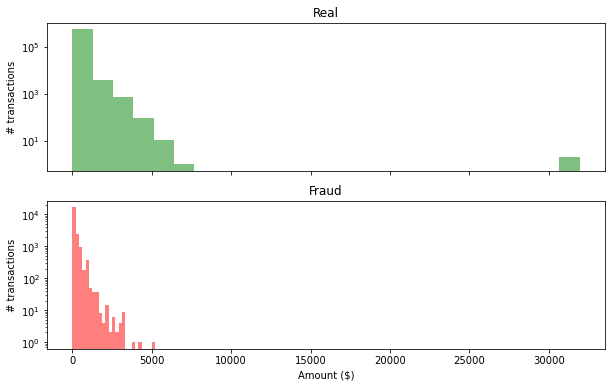

In [74]:
# Below plot is to plot distribution of feature Transaction Amount against Real and Fraud transaction to see if there is any
# pattern 

fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.TransactionAmt[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.TransactionAmt[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')

Based on above it does look like that Fraud transaction usually occur for comparatively smaller amount so that it is not easily
identified

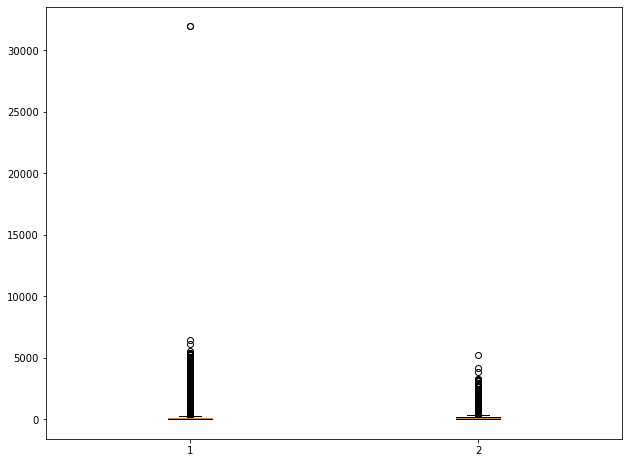

In [76]:
# Preparing box plot for showing distribution of amount for fraud and real transactions and seeany outliers and distribution

source_card_transactions_Real = source_card_transactions.TransactionAmt[source_card_transactions.isFraud==0]
source_card_transactions_Fraud = source_card_transactions.TransactionAmt[source_card_transactions.isFraud==1]

data = [source_card_transactions_Real, source_card_transactions_Fraud]
 
fig = plt.figure(figsize =(8, 6))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

Box plot result shows that there are some outliers on the amount for real transactions with extreme values.

Text(0, 0.5, '# transactions')

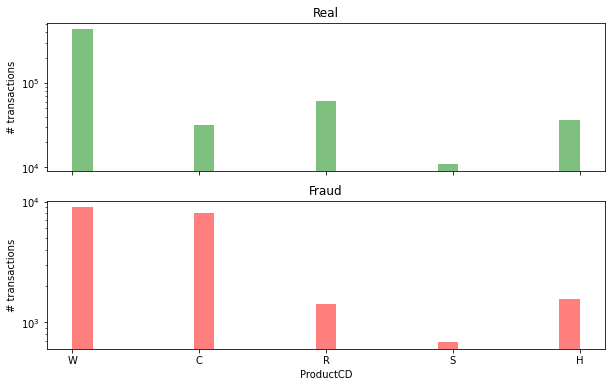

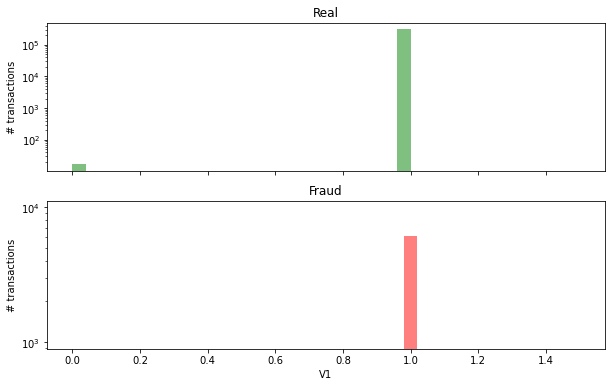

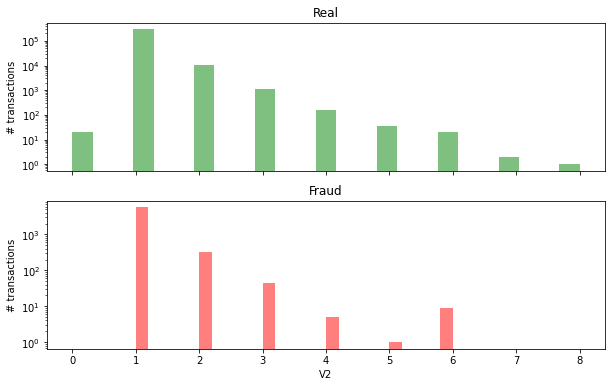

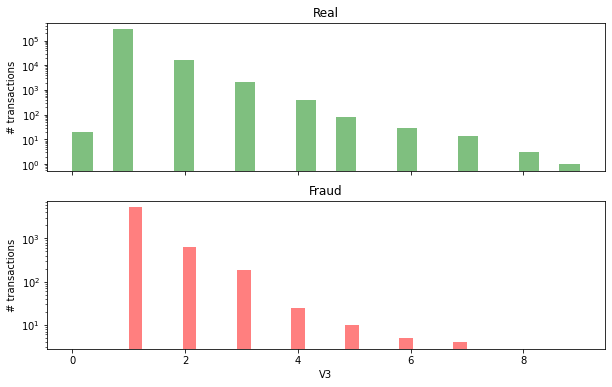

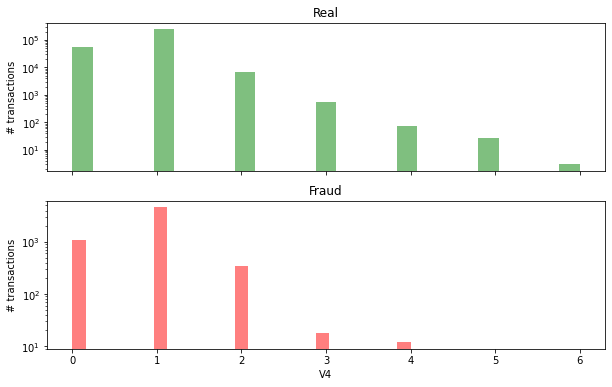

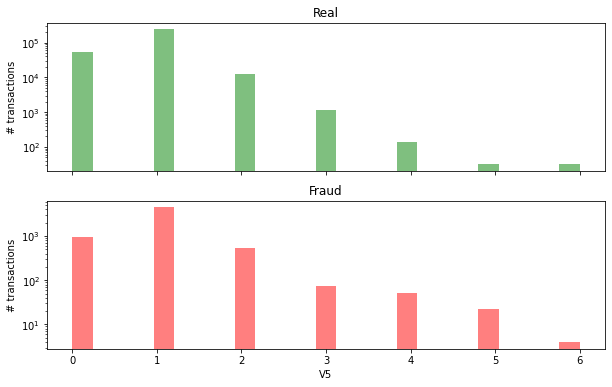

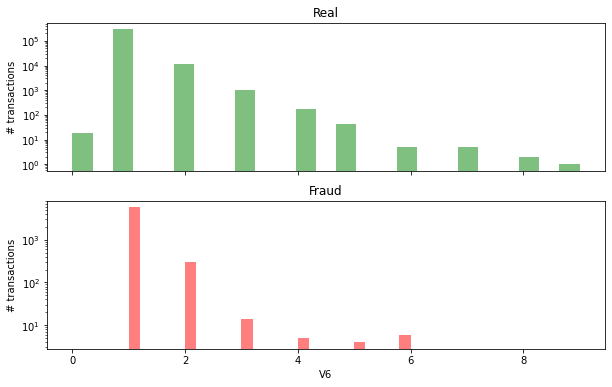

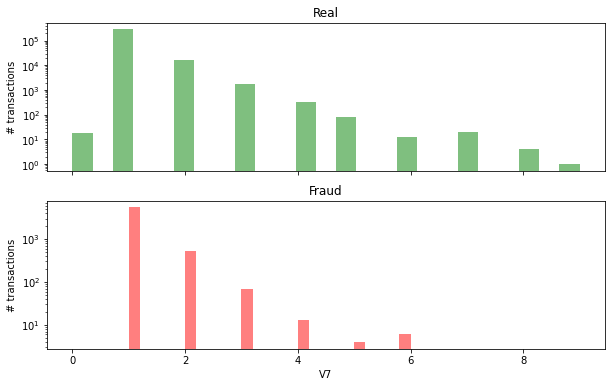

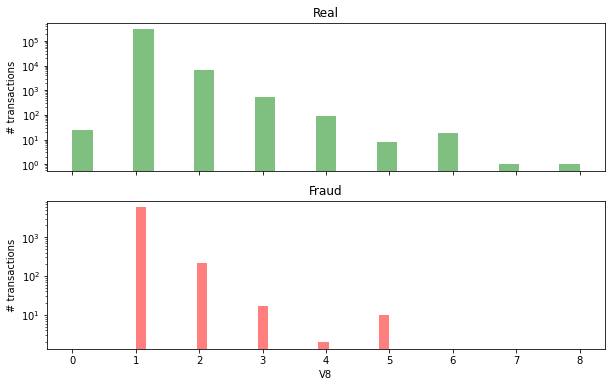

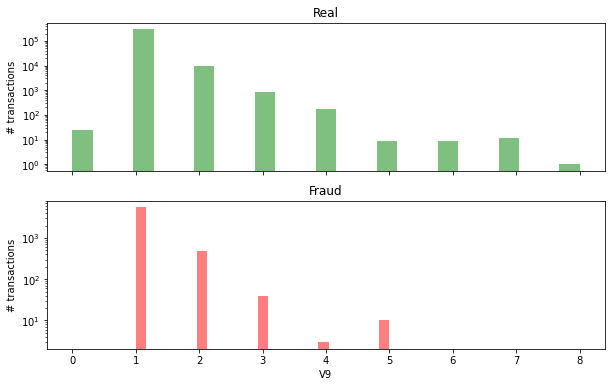

In [77]:
# There are 400+ Features in the input data source and hence I will be plotting correlations for
# 10 Features list below to get sense on how are the features related and I will be performing PCA to extract
# important features from the list of features later in this project 

# Selected Feature list =[ProductCD,V1,V2,V3,V4,V5,V6,V7,V8,V9]

fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.ProductCD[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.ProductCD[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('ProductCD')
ax4.set_ylabel('# transactions')

fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V1[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V1[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V1')
ax4.set_ylabel('# transactions')

fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V2[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V2[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V2')
ax4.set_ylabel('# transactions')


fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V3[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V3[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V3')
ax4.set_ylabel('# transactions')


fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V4[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V4[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V4')
ax4.set_ylabel('# transactions')


fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V5[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V5[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V5')
ax4.set_ylabel('# transactions')

fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V6[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V6[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V6')
ax4.set_ylabel('# transactions')

fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V7[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V7[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V7')
ax4.set_ylabel('# transactions')

fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V8[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V8[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V8')
ax4.set_ylabel('# transactions')

fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,6), sharex = True)
ax3.hist(source_card_transactions.V9[source_card_transactions.isFraud==0],bins=25,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Real') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(source_card_transactions.V9[source_card_transactions.isFraud==1],bins=25,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('V9')
ax4.set_ylabel('# transactions')

Above charts does not show the easily identifiable direction on the correlation of different features with target output. Since dataset has ~400 features hence it makes sense to perform automated dimensionality reduction method as well as drop features if there are lot of missing values before start building and training the model.

## This section is to perform data cleaning/preparation and perform feature engineering

In [18]:
# There are multiple categorical features in dataset with lot of null values and before one hot encoding can be performed
# We will need to perform data imputation. When missing values are significant for the feature then it makes sense to 
# drop the feature when there are 400+ features to work with.
# Drop categorical features from source if missing values are >25%

Drop_fields=[]
Dropped_fields_with_missing_percentage={}
for feature in categorical_fields:
    missing_value_percentage=round(100 * source_card_transactions_with_identity[feature].isnull().sum() / len(source_card_transactions_with_identity[feature]),2)
    if missing_value_percentage > 25.0:        
        Drop_fields.append(feature)
        Dropped_fields_with_missing_percentage[feature]=missing_value_percentage
        
source_card_transactions_with_identity.drop(columns=[feature for feature in Drop_fields], inplace=True)
        
print(Dropped_fields_with_missing_percentage)

{'R_emaildomain': 76.75, 'M1': 45.91, 'M2': 45.91, 'M3': 45.91, 'M4': 47.66, 'M5': 59.35, 'M6': 28.68, 'M7': 58.64, 'M8': 58.63, 'M9': 58.63, 'id_12': 75.58, 'id_15': 76.13, 'id_16': 78.1, 'id_23': 99.12, 'id_27': 99.12, 'id_28': 76.13, 'id_29': 76.13, 'id_30': 86.87, 'id_31': 76.25, 'id_33': 87.59, 'id_34': 86.82, 'id_35': 76.13, 'id_36': 76.13, 'id_37': 76.13, 'id_38': 76.13, 'DeviceType': 76.16, 'DeviceInfo': 79.91}


In [19]:
# Categorical fields list after removing fields with >25% missing values

categorical_fields = source_card_transactions_with_identity.select_dtypes(include=object).columns.tolist()
categorical_fields

['ProductCD', 'card4', 'card6', 'P_emaildomain']

In [352]:
# There are multiple numerical features in dataset with lot of null values. I would like to drop features with missing 
# values > 25% before we perform data imputation. When missing values are significant for the feature then it makes sense to 
# drop the feature when there are 400+ features to work with.
# Drop numerical features from source if missing values are > 25%

Drop_fields=[]
Dropped_fields_with_missing_percentage={}

for feature in numerical_fields:
    missing_value_percentage=round(100 * source_card_transactions_with_identity[feature].isnull().sum() / len(source_card_transactions_with_identity[feature]),2)
    if missing_value_percentage > 25.0:        
        Drop_fields.append(feature)
        Dropped_fields_with_missing_percentage[feature]=missing_value_percentage
        
source_card_transactions_with_identity.drop(columns=[feature for feature in Drop_fields], inplace=True)
        
#print(Dropped_fields_with_missing_percentage)


In [353]:
# numerical fields list after removing fields with >25% missing values

numerical_fields = source_card_transactions_with_identity.select_dtypes(exclude=object).columns.tolist()
#numerical_fields

In [361]:
# display misisng value count for each of numerical fields

for feature in numerical_fields:
    count_missing=source_card_transactions_with_identity[feature].isnull().sum() 
#    print(f"{feature} : {count_missing}")  

In [23]:
# Display distinct value counts for categprical fields

(pd.DataFrame(
    source_card_transactions_with_identity[categorical_fields]
    .melt(var_name='column', value_name='value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['column', 'counts']))

counts
column        value                   
P_emaildomain yahoo.co.jp           32
              servicios-ta.com      35
              hotmail.de            43
              yahoo.co.uk           49
              live.fr               56
...                                ...
card4         visa              384767
card6         charge card           15
              debit or credit       30
              credit            148986
              debit             439938

[72 rows x 1 columns]

In [24]:
# Based on above summarized distribution of categorical fields, I would like to categorize any value in the string 
# fields to "Other" when count of the corresponding value is less than 10000. This will help in reducing the # of features
# in output after applying one hot encoding. This will be applied to those Features where distinct value is more than 10.

Drop_fields=[]
Added_fields={}

for input_feature in categorical_fields:
    count_of_distinct_value=len(pd.unique(source_card_transactions_with_identity[input_feature]))
    if count_of_distinct_value >=10:
        input_feature_updated=f'{input_feature}_summary'
        input_feature_value_counts=source_card_transactions_with_identity[input_feature].value_counts()
        source_card_transactions_with_identity[input_feature_updated]=np.where(source_card_transactions_with_identity[input_feature].isin(input_feature_value_counts.index[input_feature_value_counts < 10000]) & source_card_transactions_with_identity[input_feature].notna(), 'Other',source_card_transactions_with_identity[input_feature])
        Drop_fields.append(input_feature)
        Added_fields[input_feature_updated]=count_of_distinct_value

source_card_transactions_with_identity.drop(columns=[feature for feature in Drop_fields], inplace=True)

print(Added_fields)   
print(Drop_fields)


{'P_emaildomain_summary': 60}
['P_emaildomain']


In [25]:
# Categorical fields list after summarizin fields with more than 10 distinct values

categorical_fields = source_card_transactions_with_identity.select_dtypes(include=object).columns.tolist()
categorical_fields

['ProductCD', 'card4', 'card6', 'P_emaildomain_summary']

In [26]:
# Checking the feature P_emaildomain distirbution after summarizing

source_card_transactions_with_identity['P_emaildomain_summary'].value_counts()

gmail.com        228355
yahoo.com        100934
Other             56258
hotmail.com       45250
anonymous.com     36998
aol.com           28289
Name: P_emaildomain_summary, dtype: int64

In [34]:
source_card_transactions_with_identity['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [35]:
source_card_transactions_with_identity['card4'].value_counts()

visa                386344
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

In [36]:
source_card_transactions_with_identity['card6'].value_counts()

debit              441509
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [ ]:
# Bucket Transaction Amount Feature into 3 buckets (Low, Medium, High) using below logic
# Low – Amount < 10
# Medium - Amount between 10 and 100
# High - Amount greater than 100

feature         = 'TransactionAmt'
conditions  = [ source_card_transactions_with_identity[feature] > 100, (source_card_transactions_with_identity[feature] <= 100) & (source_card_transactions_with_identity[feature]>= 10), source_card_transactions_with_identity[feature] < 10 ]
choices     = [ "high", 'medium', 'low' ]
    
source_card_transactions_with_identity['Transaction_Amount_bucket'] = np.select(conditions, choices, default=np.nan)

In [30]:
source_card_transactions_with_identity['Transaction_Amount_bucket'].value_counts()

medium    361824
high      221921
low         6795
Name: Transaction_Amount_bucket, dtype: int64

In [32]:
# Drop original Transaction Amount Field

source_card_transactions_with_identity.drop(columns=['TransactionAmt'], inplace=True)

In [33]:
# Fill the missing values for Categorical features with most frequent values in that field

for input_feature in categorical_fields:
    missing_value_to_replace=source_card_transactions_with_identity[input_feature].value_counts().index[0]
    print(f"missing value for {input_feature} has been updated with {missing_value_to_replace}")
    source_card_transactions_with_identity[input_feature] = source_card_transactions_with_identity[input_feature].fillna(missing_value_to_replace)


missing value for ProductCD has been updated with W
missing value for card4 has been updated with visa
missing value for card6 has been updated with debit
missing value for P_emaildomain_summary has been updated with gmail.com


In [354]:
# numerical fields list before performing imputation

numerical_fields = source_card_transactions_with_identity.select_dtypes(exclude=object).columns.tolist()
#numerical_fields

In [39]:
source_card_transactions_with_identity['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [362]:
# Fill the missing values for Categorical features with most frequent values in that field

imputer = KNNImputer(n_neighbors=5)
        
for input_feature in numerical_fields:
    missing_value_percentage=round(100 * source_card_transactions_with_identity[input_feature].isnull().sum() / len(source_card_transactions_with_identity[input_feature]),2)
    if missing_value_percentage >= 0.0 and missing_value_percentage < 10.0: 
#        print(f"working on {input_feature} to update with KNN imputer")        
        source_card_transactions_with_identity[input_feature]=imputer.fit_transform(source_card_transactions_with_identity[input_feature].to_numpy().reshape(-1,1))    
#        print(f"missing value for {input_feature} has been updated with KNN imputer")
    elif missing_value_percentage >= 10.0:
        missing_value_to_replace=source_card_transactions_with_identity[input_feature].value_counts().index[0]
        source_card_transactions_with_identity[input_feature] = source_card_transactions_with_identity[input_feature].fillna(missing_value_to_replace)
#        print(f"missing value for {input_feature} has been updated with {missing_value_to_replace}")


In [41]:
# write the imputed output from numerical_fields imputing into intermediate output so that future processing can be made quicker
%%time 
source_card_transactions_with_identity.to_csv(r'C:\Users\pujak\Downloads\intermediate_card_Transactions_identity_after_imputation.csv') 


In [42]:
del source_card_transactions_with_identity

In [153]:
%%time 
# Read intermediate credit card transaction dataset
source_card_transactions_with_identity_intermediate=pd.read_csv(r'C:\Users\pujak\Downloads\intermediate_card_Transactions_identity_after_imputation.csv', index_col=[0])

print('intermediate card transactions identity data set has been loaded successfully.')

intermediate card transactions identity data set has been loaded successfully.
Wall time: 11.8 s


In [154]:
source_card_transactions_with_identity_intermediate.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321',
       'P_emaildomain_summary', 'Transaction_Amount_bucket'],
      dtype='object', length=182)

In [10]:
# Create Target dataframe for response variable

source_card_transactions_with_identity_target=source_card_transactions_with_identity_intermediate[['isFraud']]

In [12]:
%%time
# Write target response variable dataframe to flat file for referencing it later before splitting to test and train dataset

source_card_transactions_with_identity_target.to_csv(r'C:\Users\pujak\Downloads\source_card_transactions_with_identity_target.csv')

Wall time: 1.01 s


In [28]:
source_card_transactions_with_identity_target.value_counts()

isFraud
0.0        569877
1.0         20663
dtype: int64

In [155]:
source_card_transactions_with_identity_intermediate.drop(columns=['isFraud'], inplace=True)

In [16]:
del source_card_transactions_with_identity_intermediate

In [156]:
# check if any of the feature in data frame has missing value before performing standardization on numerical fields and 
# one hot encoding on categorical fields

for input_feature in list(source_card_transactions_with_identity_intermediate.columns):
    missing_value_count=source_card_transactions_with_identity_intermediate[input_feature].isna().sum()
    if missing_value_count > 0:
        print(f"{input_feature} has missing value with count {missing_value_count}")
print("no missing value found")

no missing value found


In [157]:
# Dropping transactionid feature from the input dataset as This is uniqely generated reandom id and I don't expect 
# TransactionId to have any correlation with target variable isFraud to detect potential Fraud transaction.

source_card_transactions_with_identity_intermediate.drop(columns=['TransactionID'], inplace=True)


In [184]:
# numerical fields list before performing standardization

numerical_fields = source_card_transactions_with_identity_intermediate.select_dtypes(exclude=object).columns.tolist()
# numerical_fields (hiding display to better readability where I printed and used for my analysis)

In [181]:
# perform standard scaler on numerical features

for input_feature in numerical_fields:
    source_card_transactions_with_identity_intermediate[input_feature] = StandardScaler().fit_transform(source_card_transactions_with_identity_intermediate[input_feature].values.reshape(-1,1))

In [183]:
source_card_transactions_with_identity_intermediate.head(5)

,TransactionDT,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V314,V315,V316,V317,V318,V319,V320,V321,P_emaildomain_summary,Transaction_Amount_bucket
0,-1.577987,W,0.821695,-3.629961e-16,-0.282202,discover,-1.393802,credit,0.243321,0.069833,...,-0.249776,-0.229654,-0.048378,-0.032816,-0.058051,-0.055289,-0.088857,-0.074144,gmail.com,medium
1,-1.577986,W,-1.457558,2.646603e-01,-0.282202,mastercard,-2.367147,credit,0.347543,0.069833,...,-0.249776,-0.229654,-0.048378,-0.062213,-0.058051,-0.055289,-0.088857,-0.074144,gmail.com,medium
2,-1.577972,W,-1.068263,8.138473e-01,-0.282202,visa,-0.809796,debit,0.399654,0.069833,...,-0.249776,-0.229654,-0.048378,-0.062213,-0.058051,-0.055289,-0.088857,-0.074144,Other,medium
3,-1.577965,W,1.679858,1.305561e+00,-0.282202,mastercard,-2.002143,debit,1.921291,0.069833,...,-0.249776,-0.229654,-0.026352,0.290551,0.224768,-0.055289,-0.088857,-0.074144,yahoo.com,medium
4,-1.577964,H,-1.102133,9.671088e-01,-0.282202,mastercard,-2.367147,credit,1.337649,0.069833,...,-0.249776,-0.229654,-0.048378,-0.062213,-0.058051,-0.055289,-0.088857,-0.074144,gmail.com,medium


In [162]:
# categorical fields list before performing one hot encoding

categorical_fields = source_card_transactions_with_identity_intermediate.select_dtypes(include=object).columns.tolist()
categorical_fields

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain_summary',
 'Transaction_Amount_bucket']

In [163]:
# put categorical features in a separate dataframe

source_card_transactions_with_identity_intermediate_categorical=source_card_transactions_with_identity_intermediate[[categorical_field for categorical_field in categorical_fields]]

In [164]:
source_card_transactions_with_identity_intermediate_categorical

,ProductCD,card4,card6,P_emaildomain_summary,Transaction_Amount_bucket
0,W,discover,credit,gmail.com,medium
1,W,mastercard,credit,gmail.com,medium
2,W,visa,debit,Other,medium
3,W,mastercard,debit,yahoo.com,medium
4,H,mastercard,credit,gmail.com,medium
...,...,...,...,...,...
590535,W,visa,debit,gmail.com,medium
590536,W,mastercard,debit,gmail.com,medium
590537,W,mastercard,debit,gmail.com,medium
590538,W,mastercard,debit,aol.com,high


In [165]:
# put numerical features in a separate dataframe

source_card_transactions_with_identity_intermediate_numerical=source_card_transactions_with_identity_intermediate[[numerical_field for numerical_field in numerical_fields]]


In [166]:
source_card_transactions_with_identity_intermediate_numerical

,TransactionDT,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,86400.0,13926.0,362.555488,150.0,142.0,315.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000
1,86401.0,2755.0,404.000000,150.0,102.0,325.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,86469.0,4663.0,490.000000,150.0,166.0,330.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,86499.0,18132.0,567.000000,150.0,117.0,476.0,87.0,2.0,5.0,0.0,...,135.0,0.000000,0.000000,0.000000,50.0,1404.0,790.0,0.000000,0.000000,0.000000
4,86506.0,4497.0,514.000000,150.0,102.0,420.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,15811047.0,6550.0,362.555488,150.0,226.0,272.0,87.0,2.0,1.0,0.0,...,0.0,47.950001,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000
590536,15811049.0,10444.0,225.000000,150.0,224.0,204.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
590537,15811079.0,12037.0,595.000000,150.0,224.0,231.0,87.0,1.0,1.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
590538,15811088.0,7826.0,481.000000,150.0,224.0,387.0,87.0,1.0,1.0,0.0,...,117.0,317.500000,669.500000,317.500000,0.0,2234.0,0.0,0.000000,0.000000,0.000000


In [167]:
# perform one hot encoding on categorical features

# categorical features list 
categorical_fields

# instantiate the one hot encoder and drop the first field after one hot encoding
one_hot_encoder = OneHotEncoder(sparse=False, drop = "first")

# apply the one hot encoder logic 
one_hot_encoder_output_array = one_hot_encoder.fit_transform(source_card_transactions_with_identity_intermediate_categorical[categorical_fields])


In [168]:
# Extract one hot encoded feature names using the categorical variables

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_fields)
encoder_feature_names

array(['ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W',
       'card4_discover', 'card4_mastercard', 'card4_visa', 'card6_credit',
       'card6_debit', 'card6_debit or credit',
       'P_emaildomain_summary_anonymous.com',
       'P_emaildomain_summary_aol.com', 'P_emaildomain_summary_gmail.com',
       'P_emaildomain_summary_hotmail.com',
       'P_emaildomain_summary_yahoo.com', 'Transaction_Amount_bucket_low',
       'Transaction_Amount_bucket_medium'], dtype=object)

In [169]:
# create a dataframe to hold the one hot encoded variables

one_hot_encoded_features_df = pd.DataFrame(one_hot_encoder_output_array, columns = encoder_feature_names)


In [170]:
one_hot_encoded_features_df

,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,P_emaildomain_summary_anonymous.com,P_emaildomain_summary_aol.com,P_emaildomain_summary_gmail.com,P_emaildomain_summary_hotmail.com,P_emaildomain_summary_yahoo.com,Transaction_Amount_bucket_low,Transaction_Amount_bucket_medium
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
590536,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
590537,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
590538,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [171]:
one_hot_encoded_features_df.columns

Index(['ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W',
       'card4_discover', 'card4_mastercard', 'card4_visa', 'card6_credit',
       'card6_debit', 'card6_debit or credit',
       'P_emaildomain_summary_anonymous.com', 'P_emaildomain_summary_aol.com',
       'P_emaildomain_summary_gmail.com', 'P_emaildomain_summary_hotmail.com',
       'P_emaildomain_summary_yahoo.com', 'Transaction_Amount_bucket_low',
       'Transaction_Amount_bucket_medium'],
      dtype='object')

In [96]:
# perform PCA analysis on numerical features and select top 30 features and check if it is explaining > 80% and if yes then 
# continue with 30 features in output for building and training the model

pca_30 =PCA(n_components=30, random_state=42)
pca_30.fit(source_card_transactions_with_identity_intermediate_numerical)
output_pca_30=pca_30.transform(source_card_transactions_with_identity_intermediate_numerical)


In [97]:
sum(pca_30.explained_variance_ratio_*100)

83.63267972318543

In [98]:
# Top 30 features from PCA output is explaining > 83% of variance hence I would move forward with this to build the model

explained_variance = pca_30.explained_variance_ratio_*100
explained_variance

array([17.68527124, 15.50233248,  5.82802737,  4.70893123,  4.14493417,
        3.6501903 ,  2.88914026,  2.41515258,  2.30646766,  1.90774482,
        1.86600057,  1.83382296,  1.7448342 ,  1.60140119,  1.48886072,
        1.44176063,  1.30611916,  1.19769127,  1.18245123,  1.11435605,
        1.06959223,  0.99790814,  0.96127979,  0.80903303,  0.77226105,
        0.7350483 ,  0.63750446,  0.62505542,  0.61642084,  0.59308634])

In [100]:
#iterate over the components to print the explained variance
for i in range(0, 30):
    print(f"Component {i:>2} accounts for {explained_variance[i]:>2.2f}% of variance")

Component  0 accounts for 17.69% of variance
Component  1 accounts for 15.50% of variance
Component  2 accounts for 5.83% of variance
Component  3 accounts for 4.71% of variance
Component  4 accounts for 4.14% of variance
Component  5 accounts for 3.65% of variance
Component  6 accounts for 2.89% of variance
Component  7 accounts for 2.42% of variance
Component  8 accounts for 2.31% of variance
Component  9 accounts for 1.91% of variance
Component 10 accounts for 1.87% of variance
Component 11 accounts for 1.83% of variance
Component 12 accounts for 1.74% of variance
Component 13 accounts for 1.60% of variance
Component 14 accounts for 1.49% of variance
Component 15 accounts for 1.44% of variance
Component 16 accounts for 1.31% of variance
Component 17 accounts for 1.20% of variance
Component 18 accounts for 1.18% of variance
Component 19 accounts for 1.11% of variance
Component 20 accounts for 1.07% of variance
Component 21 accounts for 1.00% of variance
Component 22 accounts for 0.96

In [101]:
n_pcs= pca_30.components_.shape[0]
n_pcs

30

In [355]:
most_important = [np.abs(pca_30.components_[i]).argmax() for i in range(n_pcs)]
#most_important

In [356]:
PCA_important_features=[source_card_transactions_with_identity_intermediate_numerical.columns[most_important[i]] for i in range(n_pcs)]
#PCA_important_features

In [104]:
source_card_transactions_with_identity_numerical_after_PCA=source_card_transactions_with_identity_intermediate_numerical[PCA_important_features]

In [105]:
source_card_transactions_with_identity_numerical_after_PCA

,V308,V57,C11,V114,V283,V312,V70,V319,V19,V28,...,V284,V301,V121,V56,D15,V106,V107,addr2,card5,addr1
0,-0.076248,-0.339743,-0.087363,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,-0.261636,-0.163544,-0.06375,-0.170255,-0.710143,-0.090174,0.020508,0.069833,-1.393802,0.243321
1,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,-0.261636,-0.163544,-0.06375,-0.170255,-0.710143,-0.090174,0.020508,0.069833,-2.367147,0.347543
2,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,-0.261636,-0.163544,-0.06375,-0.170255,0.898765,-0.090174,0.020508,0.069833,-0.809796,0.399654
3,0.229852,-0.339743,-0.097964,-0.084414,-0.636532,0.556719,-0.662942,-0.055289,0.398048,-0.024882,...,-0.261636,-0.163544,-0.06375,-0.170255,-0.143195,-0.090174,0.020508,0.069833,-2.002143,1.921291
4,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,-0.261636,-0.163544,-0.06375,-0.170255,-0.710143,-0.090174,0.020508,0.069833,-2.367147,1.337649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,1.206246,-0.055289,-2.090159,-0.024882,...,-0.261636,-0.163544,-0.06375,-0.170255,-0.424115,-0.090174,0.020508,0.069833,0.650221,-0.204832
590536,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,-0.261636,-0.163544,-0.06375,-0.170255,-0.710143,-0.090174,0.020508,0.069833,0.601554,-0.913540
590537,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,1.206246,-0.055289,0.398048,-0.024882,...,-0.261636,-0.163544,-0.06375,-0.170255,-0.710143,-0.090174,0.020508,0.069833,0.601554,-0.632142
590538,-0.037531,-0.339743,-0.097964,-0.084414,3.859137,0.452145,-0.662942,-0.055289,2.886256,-0.024882,...,2.693273,-0.163544,-0.06375,-0.170255,-0.597775,-0.090174,0.020508,0.069833,0.601554,0.993718


In [106]:
# concatenate the new dataframe back to the original input variables dataframe
source_card_transactions_with_identity_after_merge = pd.concat([source_card_transactions_with_identity_numerical_after_PCA.reset_index(drop=True), one_hot_encoded_features_df.reset_index(drop=True)], axis = 1)


In [108]:
source_card_transactions_with_identity_after_merge.head()

,V308,V57,C11,V114,V283,V312,V70,V319,V19,V28,...,card6_credit,card6_debit,card6_debit or credit,P_emaildomain_summary_anonymous.com,P_emaildomain_summary_aol.com,P_emaildomain_summary_gmail.com,P_emaildomain_summary_hotmail.com,P_emaildomain_summary_yahoo.com,Transaction_Amount_bucket_low,Transaction_Amount_bucket_medium
0,-0.076248,-0.339743,-0.087363,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.229852,-0.339743,-0.097964,-0.084414,-0.636532,0.556719,-0.662942,-0.055289,0.398048,-0.024882,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.076248,-0.339743,-0.097964,-0.084414,0.005707,-0.227588,-0.662942,-0.055289,0.398048,-0.024882,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [110]:
%%time 
# store preprocessed source dataset for training and testing

source_card_transactions_with_identity_after_merge.to_csv(r'C:\Users\pujak\Downloads\preprocessed_card_Transactions_identity.csv') 


Wall time: 49 s


In [120]:
del source_card_transactions_with_identity_numerical_after_PCA
del source_card_transactions_with_identity_after_merge
del source_card_transactions_with_identity_intermediate

In [3]:
%%time 
# Read preprocessed source dataset for training and testing

source_card_transactions_with_identity_after_merge=pd.read_csv(r'C:\Users\pujak\Downloads\preprocessed_card_Transactions_identity.csv',index_col=[0])

print('final preprocessed card transactions data set with identity has been loaded successfully.')

final preprocessed card transactions data set with identity has been loaded successfully.
Wall time: 5.29 s


In [4]:
# Rename features to make more easily confgurable for prediction through app

source_card_transactions_with_identity_after_merge.columns = source_card_transactions_with_identity_after_merge.columns.str.replace('.', '_')
source_card_transactions_with_identity_after_merge.columns = source_card_transactions_with_identity_after_merge.columns.str.replace(' ', '_')


In [5]:
source_card_transactions_with_identity_after_merge.columns

Index(['V308', 'V57', 'C11', 'V114', 'V283', 'V312', 'V70', 'V319', 'V19',
       'V28', 'V292', 'V28_1', 'V82', 'V311', 'V86', 'V26', 'V300', 'C9',
       'V301', 'V88', 'V284', 'V301_1', 'V121', 'V56', 'D15', 'V106', 'V107',
       'addr2', 'card5', 'addr1', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'card6_credit', 'card6_debit', 'card6_debit_or_credit',
       'P_emaildomain_summary_anonymous_com', 'P_emaildomain_summary_aol_com',
       'P_emaildomain_summary_gmail_com', 'P_emaildomain_summary_hotmail_com',
       'P_emaildomain_summary_yahoo_com', 'Transaction_Amount_bucket_low',
       'Transaction_Amount_bucket_medium'],
      dtype='object')

In [13]:
%%time 
# Read target variable dataset
source_card_transactions_with_identity_target=pd.read_csv(r'C:\Users\pujak\Downloads\source_card_transactions_with_identity_target.csv', index_col=[0])


Wall time: 153 ms


In [14]:
source_card_transactions_with_identity_target

,isFraud
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
590535,0.0
590536,0.0
590537,0.0
590538,0.0


In [15]:
# Train Test Split by keeping 80% for training and 20% for testing

x=source_card_transactions_with_identity_after_merge
y=source_card_transactions_with_identity_target

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [17]:
# Perform SMOTE on training dataset to balance observations for Fraud transactions and Real transacrions
# Here I am using sampling strategy of 0.4 after trying different sampling strategy including balancing both class equally
# I found that model performance is comparatively better when I use sampling strategy between 0.4-0.6 and here I am going
# with sampling strategy of 0.4
# Here I have applied sampling strategy SMOTE to oversample the minority class (Fraud) on traning dataset only.

X_resample, y_resample = SMOTE(sampling_strategy=0.4).fit_resample(xTrain, yTrain)

In [18]:
X_resample.shape

(638149, 47)

isFraud distribution as pie chart after applying SMOTE:


<Figure size 864x576 with 0 Axes>

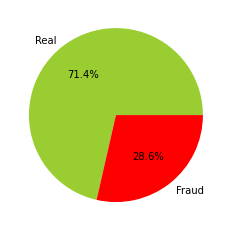

In [19]:
# Check isFraud target variable that has 0 value for Real transactions and 1 for Fraud
plt.figure(figsize=(12,8))
print("isFraud distribution as pie chart after applying SMOTE:")
fig, ax = plt.subplots(1, 1)
ax.pie(y_resample.value_counts(),autopct='%1.1f%%', labels=['Real','Fraud'], colors=['yellowgreen','r'])
plt.axis('on')
plt.ylabel('')
plt.show()

In [173]:
# I am going to prepare another version of training and test dataset where there will be no standardization performed
# on numerical features, no oversampling and No PCA applied. There will be one hot encoding performed on categorical 
# features and this dataset will be sued for Decision Tree and Random Forest algorithm to train and evaluate the model
# while searching for best performing model

# I will be using intermediate dataset created earlier after performing cleaning and imputation to generate dataset for
# future use in building and training models.

source_card_transactions_with_identity_before_standardization_PCA=pd.concat([source_card_transactions_with_identity_intermediate_numerical.reset_index(drop=True), one_hot_encoded_features_df.reset_index(drop=True)], axis = 1)


In [176]:
# Rename features to make more easily confgurable for prediction through app

source_card_transactions_with_identity_before_standardization_PCA.columns = source_card_transactions_with_identity_before_standardization_PCA.columns.str.replace('.', '_')
source_card_transactions_with_identity_before_standardization_PCA.columns = source_card_transactions_with_identity_before_standardization_PCA.columns.str.replace(' ', '_')

In [177]:
source_card_transactions_with_identity_before_standardization_PCA.head(5)

,TransactionDT,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,...,card6_credit,card6_debit,card6_debit_or_credit,P_emaildomain_summary_anonymous_com,P_emaildomain_summary_aol_com,P_emaildomain_summary_gmail_com,P_emaildomain_summary_hotmail_com,P_emaildomain_summary_yahoo_com,Transaction_Amount_bucket_low,Transaction_Amount_bucket_medium
0,86400.0,13926.0,362.555488,150.0,142.0,315.0,87.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,86401.0,2755.0,404.000000,150.0,102.0,325.0,87.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,86469.0,4663.0,490.000000,150.0,166.0,330.0,87.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,86499.0,18132.0,567.000000,150.0,117.0,476.0,87.0,2.0,5.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,86506.0,4497.0,514.000000,150.0,102.0,420.0,87.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [178]:
%%time 
# Write output before applying standardization and PCA

source_card_transactions_with_identity_before_standardization_PCA.to_csv(r'C:\Users\pujak\Downloads\preprocessed_card_Transactions_identity_before_standardization_PCA.csv')


Wall time: 1min 26s


In [179]:
%%time
# Read preprocess data before applying standardization and PCA for decision tree and random forest algorithm

source_card_transactions_with_identity_preprocessed=pd.read_csv(r'C:\Users\pujak\Downloads\preprocessed_card_Transactions_identity_before_standardization_PCA.csv', index_col=[0])


Wall time: 10.9 s


In [180]:
del source_card_transactions_with_identity_before_standardization_PCA

In [185]:
del source_card_transactions_with_identity_intermediate_numerical
del source_card_transactions_with_identity_intermediate

In [186]:
source_card_transactions_with_identity_preprocessed.columns

Index(['TransactionDT', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
       'C1', 'C2', 'C3',
       ...
       'card6_credit', 'card6_debit', 'card6_debit_or_credit',
       'P_emaildomain_summary_anonymous_com', 'P_emaildomain_summary_aol_com',
       'P_emaildomain_summary_gmail_com', 'P_emaildomain_summary_hotmail_com',
       'P_emaildomain_summary_yahoo_com', 'Transaction_Amount_bucket_low',
       'Transaction_Amount_bucket_medium'],
      dtype='object', length=192)

In [187]:
# Train Test Split by keeping 80% for training and 20% for testing
# I am naming here as comprehensive dataset as this dataset has not been sent through PCA and will be used for decision Tree
# and Random Forest algorithm

x_comp=source_card_transactions_with_identity_preprocessed
y_comp=source_card_transactions_with_identity_target

In [281]:
# Naming here training and testing dataset as comprehensive 

xTrain_comp, xTest_comp, yTrain_comp, yTest_comp = train_test_split(x_comp, y_comp, test_size = 0.2, random_state = 0)


## This section is to explore building different ML models and perform tuning on the same

# Defining reusable functions for multiple models

In [43]:
# Plot Confusion Matrix

# defining the plot function

def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [55]:
# Prints scores for different metrics captured for the model

def print_scores(y_test,y_pred,y_pred_prob):
    precision,recall,_ = precision_recall_curve(y_test,y_pred_prob[:,1])
    print('accuracy_score : ',accuracy_score(y_test,y_pred))
    print('precision_score : ',precision_score(y_test,y_pred))
    print('recall_score : ',recall_score(y_test,y_pred))
    print('f1 score : ', f1_score(y_test,y_pred))
    print('AUC score : ', auc(recall,precision))
    print('ROC_AUC score : ', roc_auc_score(y_test, y_pred_prob[:,1]))

# Working with Logistic Regression Model

In [47]:
# Using train and test dataset before perfoming SMOTE to balance the target variables in input dataset. This is to perform
# and validate if model can perform good job with current representation of Fraud transactions.

lr = LogisticRegression(solver='lbfgs', max_iter=1000)

lr.fit(xTrain, yTrain.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [36]:
# Calculating score on training dataset using dataset before SMOTE was performed

lr.score(xTrain, yTrain)

0.9665115826192976

In [71]:
lr_pred,lr_prob = lr.predict(xTest),lr.predict_proba(xTest)

In [72]:
print("Logistic Regression model scores on test dataset before SMOTE: \n")
print_scores(yTest,lr_pred,lr_prob)

Logistic Regression model scores on test dataset before SMOTE: 

accuracy_score :  0.9672926474074576
precision_score :  0.715261958997722
recall_score :  0.07749259624876605
f1 score :  0.1398352260075707
AUC score :  0.24792532566411368
ROC_AUC score :  0.8084281358887732


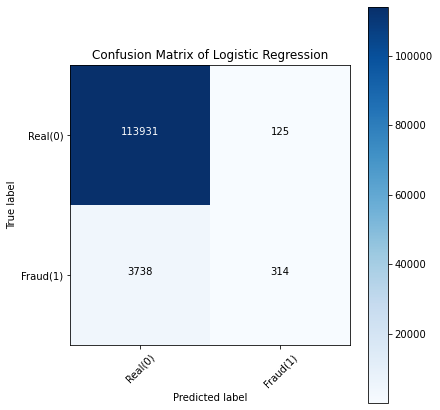

In [73]:
# Compute confusion matrix for the model before SMOTE was performed

lr_matrix = confusion_matrix(yTest, lr_pred, labels = [0, 1]) # Logistic Regression

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

lr_cm_plot = plot_confusion_matrix(lr_matrix, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Logistic Regression')
plt.show()

In [66]:
# Using train and test dataset after perfoming SMOTE to balance the target variables in input dataset. This is to validate 
# if model can perform good job after target variable output classes are balanced.

lr_after_SMOTE = LogisticRegression(solver='lbfgs', max_iter=1000)

lr_after_SMOTE.fit(X_resample, y_resample.values.ravel())


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
# Calculating score on training dataset using dataset after SMOTE was performed

lr_after_SMOTE.score(X_resample, y_resample)

0.7871625592142274

In [74]:
lr_pred_after_SMOTE,lr_prob_after_SMOTE = lr_after_SMOTE.predict(xTest),lr_after_SMOTE.predict_proba(xTest)

In [75]:
print("Logistic Regression model scores on test dataset after SMOTE: \n")
print_scores(yTest,lr_pred_after_SMOTE,lr_prob_after_SMOTE)

Logistic Regression model scores on test dataset after SMOTE: 

accuracy_score :  0.9149168557591357
precision_score :  0.18453445554971068
recall_score :  0.4328726554787759
f1 score :  0.2587593125322712
AUC score :  0.23448737800676722
ROC_AUC score :  0.8120927555996635


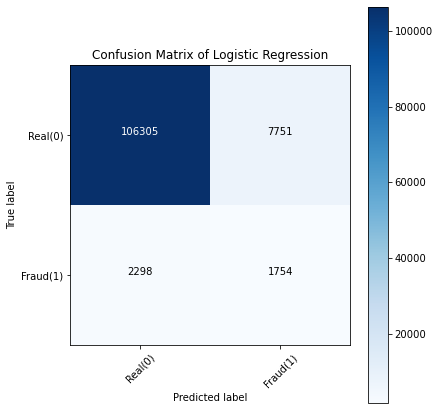

In [76]:
# Compute confusion matrix for the model after SMOTE was performed

lr_matrix = confusion_matrix(yTest, lr_pred_after_SMOTE, labels = [0, 1]) # Logistic Regression

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

lr_cm_plot = plot_confusion_matrix(lr_matrix, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Logistic Regression')
plt.show()

Here I find that logistic regression model accuracy has dropped slightly however F1 score went up when using model trained on data after oversampling (SMOTE) was performed hence for performing hyperparameter tuning for logistic regression model I will be using the training dataset after applying SMOTE.

In [81]:
# Performing hyperparameter tuning on Logistic Regression model

# I am using solver 'lbfgs' and max iteration 1000 as I found that gridSearch is slow when multiple parameters with multiple
# different options are used and considering the training dataset volume I am restricting the options to allow my local machine
# to handle it successfully.

# I am using cv of 3 to reduce the amount of time taken to find the optial parameter for best performing model while also
# allowing cross validatio to be performed effectively.

log_reg_params = {"penalty": ['l1','l2'], 'C': [ 0.01, 0.1, 1], 'solver' :['lbfgs', 'liblinear']}

grid_log_reg = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000),
                            log_reg_params,
                            scoring='accuracy',
                            cv=3)

grid_log_reg.fit(X_resample, y_resample.values.ravel())

# Getting the best parameters for the model
print("Tuned Hyperparameters :", grid_log_reg.best_params_)
print("Accuracy :",grid_log_reg.best_score_)


Tuned Hyperparameters : {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.7880636035888179


In [84]:
# Training the logistic model using best parameters retireved from gridsearchCV and then applying to test dataset to 
# find model metrics

lr_after_hypertuning = LogisticRegression(solver='lbfgs', max_iter=1000, C= 0.01, penalty= 'l2')

lr_after_hypertuning.fit(X_resample, y_resample.values.ravel())


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
# Calculating score on training dataset using dataset after SMOTE was performed

lr_after_hypertuning.score(X_resample, y_resample)

0.7878238467818645

In [86]:
lr_pred_after_hypertuning,lr_prob_after_hypertuning = lr_after_hypertuning.predict(xTest),lr_after_hypertuning.predict_proba(xTest)

print("Logistic Regression model scores on test dataset after performing hypertuning: \n")
print_scores(yTest,lr_pred_after_hypertuning,lr_prob_after_hypertuning)

Logistic Regression model scores on test dataset after performing hypertuning: 

accuracy_score :  0.9171774985606395
precision_score :  0.18878991961764066
recall_score :  0.428923988153998
f1 score :  0.2621813244833308
AUC score :  0.2344248026372859
ROC_AUC score :  0.8123184353388415


Above Metrics is final output for Logistic Regression Model

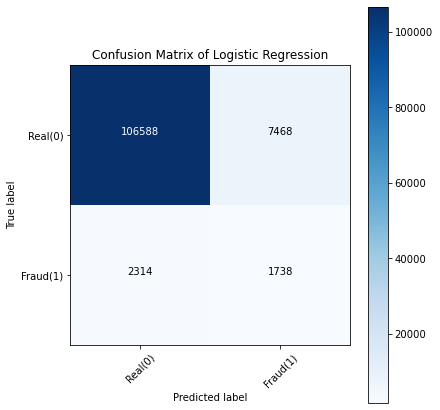

In [87]:
# Compute confusion matrix for the model after hypertuning was performed

lr_matrix = confusion_matrix(yTest, lr_pred_after_hypertuning, labels = [0, 1]) # Logistic Regression

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

lr_cm_plot = plot_confusion_matrix(lr_matrix, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Logistic Regression')
plt.show()

# Working on Decision Tree Algorithm

In [189]:
# Apply Decision Tree algorithm on the comprehensive training dataset prepared

dtc = DecisionTreeClassifier()
dtc.fit(xTrain_comp,yTrain_comp)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')

In [191]:
# Calculating score on training dataset

dtc.score(xTrain_comp,yTrain_comp)

1.0

Above score of 1.0 is expected for decision tree algorithm as it fits all the training data in tree and tend to be overfit
unless restricted with parameters like max_depth, max_features etc.

In [192]:
# Generate model performance on testing (validation) dataset

dtc_pred,dtc_prob = dtc.predict(xTest_comp),dtc.predict_proba(xTest_comp)

print("Decision Tree model scores on test dataset : \n")
print_scores(yTest_comp,dtc_pred,dtc_prob)

Decision Tree model scores on test dataset : 

accuracy_score :  0.9687150743387408
precision_score :  0.5403207589789926
recall_score :  0.5903257650542941
f1 score :  0.5642174784762355
AUC score :  0.5723507284033402
ROC_AUC score :  0.7862418262039375


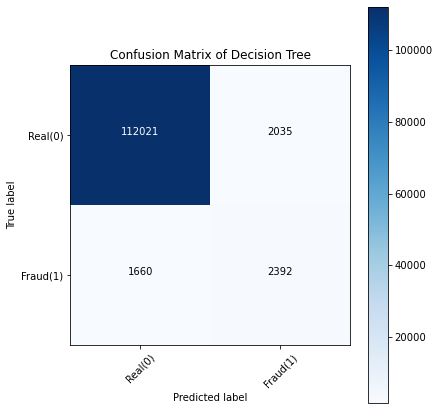

In [193]:
# Compute confusion matrix for the model

dtc_matrix = confusion_matrix(yTest_comp, dtc_pred, labels = [0, 1]) # Decision Tree algorithm

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

dtc_cm_plot = plot_confusion_matrix(dtc_matrix, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Decision Tree')
plt.show()

In [364]:
# As next step to further improve Decision Tree algorithm performance, I will be selecting important features which
# constitute > 80% of variability and then I will be applying different parameter values to find the optimal parameters
# This will help in reducing the features in the dataset used for training and validation and enhance the model training
# performance otherwise I am finding the model training keeps running for multiple hours for some cases.

feature_importance = dtc.feature_importances_

feature_importance_dict={}

# summarize feature importance
for i,v in enumerate(feature_importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))

In [202]:
feature_importance = dtc.feature_importances_

feature_importance_dict={}

# summarize feature importance
for i,v in enumerate(feature_importance):
    feature_importance_dict[i]=v

In [206]:
feature_importance_list_sorted=sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

In [212]:
important_feature_location=[]
important_feature_importance=[]
importance=0.0
for i in feature_importance_list_sorted:
    importance=i[1] + importance
    if importance>=0.8:
        break
    important_feature_location.append(i[0])
    important_feature_importance.append(i[1])
    

In [215]:
len(important_feature_location)

42

In [357]:
xTrain_selected_features =[xTrain_comp.columns[important_feature_location[i]] for i in range (len(important_feature_location))]
#xTrain_selected_features

In [227]:
xTrain_selected=xTrain_comp[xTrain_selected_features]

In [358]:
xTest_selected_features =[xTest_comp.columns[important_feature_location[i]] for i in range (len(important_feature_location))]
#xTest_selected_features

In [229]:
xTest_selected=xTest_comp[xTest_selected_features]

In [232]:
# Here I am going to use GridsearchCV to look for best parameters and passing different parameters to find best parameters
# and score. I found that data volumne is large ~500 MB (~600k observations with 400+ features) and hence I am finding the
# GridSearchCV keeps running for multiple hours and I am trying to assess model using multiple algorithm hence I am keeping
# limited number of parameters for performing gridsearch.

param_grid = {
 'max_depth':[8,16],
 'min_samples_split':[40,80],
 'min_samples_leaf': [4,8]  
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=1)
gridSearch.fit(xTrain_selected, yTrain_comp)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

Best score:  0.974815425093443
Best parameters:  {'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 40}


In [233]:
# Evaluate Decision Tree model using best parameter from gridsearch output

dtc_hypertuning = DecisionTreeClassifier(max_depth=16,min_samples_leaf=4,min_samples_split=40)
dtc_hypertuning.fit(xTrain_selected,yTrain_comp)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=16, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=4,
                       min_samples_split=40, min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')

In [234]:
# Generate model performance on testing (validation) dataset

dtc_pred_hypertuning,dtc_prob_hypertuning = dtc_hypertuning.predict(xTest_selected),dtc_hypertuning.predict_proba(xTest_selected)

print("Decision Tree model scores on test dataset after performing hypertuning : \n")
print_scores(yTest_comp,dtc_pred_hypertuning,dtc_prob_hypertuning)

Decision Tree model scores on test dataset after performing hypertuning : 

accuracy_score :  0.9755478037050835
precision_score :  0.7779369627507163
recall_score :  0.40202369200394866
f1 score :  0.5301008786202408
AUC score :  0.5298767163839708
ROC_AUC score :  0.849328252947358


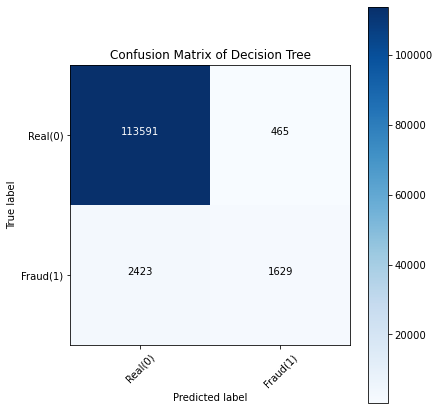

In [235]:
# Compute confusion matrix for the model after performing hypertuning

dtc_matrix_hypertuning = confusion_matrix(yTest_comp, dtc_pred_hypertuning, labels = [0, 1]) # Decision Tree algorithm

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

dtc_cm_plot = plot_confusion_matrix(dtc_matrix_hypertuning, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Decision Tree')
plt.show()

# Working with Random Forest Algorithm

In [264]:
# Here I will be applying Ensemble techniques to peform model training and evaluation while searching for best performing
# model for my use case.

# Apply Random Forest on the comprehensive data prepared above and used for training Decision Tree algorithms

RF_clf = RandomForestClassifier()

RF_clf.fit(xTrain_comp,yTrain_comp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [265]:
# Generate model performance on testing (validation) dataset

RF_pred,RF_prob = RF_clf.predict(xTest_comp),RF_clf.predict_proba(xTest_comp)

In [266]:
print("Random Forest model scores on test dataset : \n")
print_scores(yTest_comp,RF_pred,RF_prob)

Random Forest model scores on test dataset : 

accuracy_score :  0.9793155417075896
precision_score :  0.8712505768343332
recall_score :  0.46594274432379074
f1 score :  0.6071715709921208
AUC score :  0.6850272295202784
ROC_AUC score :  0.9081004639414066


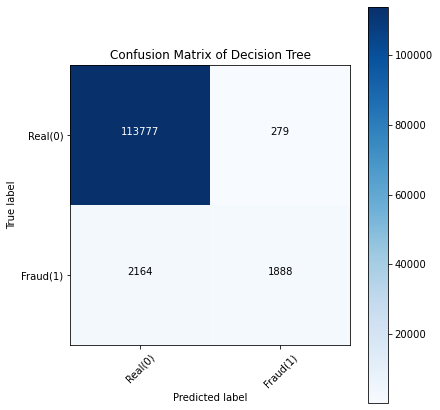

In [267]:
# Compute confusion matrix for the model

rf_matrix = confusion_matrix(yTest_comp, RF_pred, labels = [0, 1]) # Random Forest algorithm

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

rf_cm_plot = plot_confusion_matrix(rf_matrix, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Decision Tree')
plt.show()


In [363]:
# As next step to further improve Random Forest algorithm performance, I will be selecting important features which
# constitute > 70% of variability and then I will be applying different parameter values to find the optimal parameters
# This will help in reducing the features in the dataset used for training and validation and enhance the model training
# performance otherwise I am finding the model training keeps running for multiple hours for some cases.

feature_importance = RF_clf.feature_importances_

feature_importance_dict={}

# summarize feature importance
for i,v in enumerate(feature_importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))

In [270]:
feature_importance = RF_clf.feature_importances_

feature_importance_dict={}

# summarize feature importance
for i,v in enumerate(feature_importance):
    feature_importance_dict[i]=v

In [284]:
feature_importance_list_sorted=sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

important_feature_location=[]
important_feature_importance=[]
importance=0.0
for i in feature_importance_list_sorted:
    importance=i[1] + importance
    if importance>=0.7:
        break
    important_feature_location.append(i[0])
    important_feature_importance.append(i[1])


In [286]:
len(important_feature_location)

46

In [359]:
xTrain_selected_features =[xTrain_comp.columns[important_feature_location[i]] for i in range (len(important_feature_location))]
#xTrain_selected_features

In [288]:
xTrain_selected=xTrain_comp[xTrain_selected_features]

In [289]:
# Using the same list of selected Feature, I will be creating Test dataset

xTest_selected=xTest_comp[xTrain_selected_features]

In [291]:
# Perform model training and testing using the selected features to check if model performance has changed

RF_clf_selected = RandomForestClassifier()

RF_clf_selected.fit(xTrain_selected,yTrain_comp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [292]:
# Generate model performance on testing (validation) dataset

RF_pred_selected,RF_prob_selected = RF_clf_selected.predict(xTest_selected),RF_clf_selected.predict_proba(xTest_selected)


In [293]:
print("Random Forest model scores on test dataset after selecting important features : \n")
print_scores(yTest_comp,RF_pred_selected,RF_prob_selected)

Random Forest model scores on test dataset after selecting important features : 

accuracy_score :  0.9792647407457581
precision_score :  0.8573339277753009
recall_score :  0.4745804540967424
f1 score :  0.6109610802223987
AUC score :  0.6897978929175875
ROC_AUC score :  0.9108974903635774


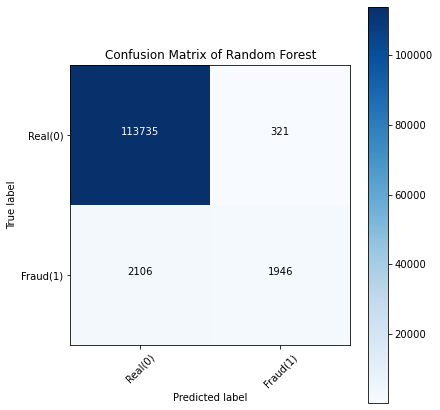

In [335]:
# Compute confusion matrix for the model

rf_matrix_selected = confusion_matrix(yTest_comp, RF_pred_selected, labels = [0, 1]) # Random Forest algorithm

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

rf_cm_plot_selected = plot_confusion_matrix(rf_matrix_selected, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Random Forest')
plt.show()

I find that model is doing good when I selected important features explaining the variability of 70% and hence I am planning to select features which explains variability of 60% as next step to reduce the # of features further which will help in maintaining the feature list while developing the web application without having to sacrifice on the model performance.

In [296]:
important_feature_location=[]
important_feature_importance=[]
importance=0.0
for i in feature_importance_list_sorted:
    importance=i[1] + importance
    if importance>=0.6:
        break
    important_feature_location.append(i[0])
    important_feature_importance.append(i[1])

In [297]:
len(important_feature_location)

30

In [360]:
xTrain_selected_features =[xTrain_comp.columns[important_feature_location[i]] for i in range (len(important_feature_location))]
#xTrain_selected_features

In [299]:
xTrain_selected=xTrain_comp[xTrain_selected_features]
xTest_selected=xTest_comp[xTrain_selected_features]

In [301]:
# Build and Train Random Forest model using selected features based on 60% variability

RF_clf_selected = RandomForestClassifier()

RF_clf_selected.fit(xTrain_selected,yTrain_comp)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [302]:
# Generate model performance on testing (validation) dataset

RF_pred_selected,RF_prob_selected = RF_clf_selected.predict(xTest_selected),RF_clf_selected.predict_proba(xTest_selected)


In [303]:
print("Random Forest model scores on test dataset after selecting important features : \n")
print_scores(yTest_comp,RF_pred_selected,RF_prob_selected)

Random Forest model scores on test dataset after selecting important features : 

accuracy_score :  0.9794510109391404
precision_score :  0.8584031760035289
recall_score :  0.48025666337611056
f1 score :  0.61592024054439
AUC score :  0.695418139541437
ROC_AUC score :  0.9103091778888202


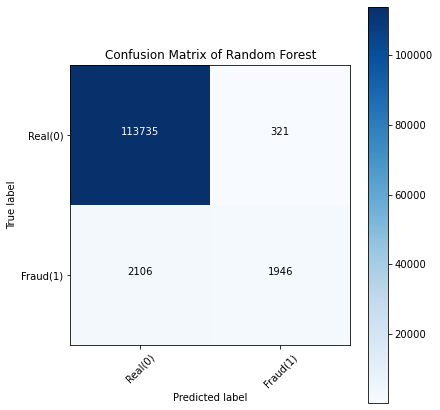

In [334]:
# Compute confusion matrix for the model

rf_matrix_selected = confusion_matrix(yTest_comp, RF_pred_selected, labels = [0, 1]) # Random Forest algorithm

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

rf_cm_plot_selected = plot_confusion_matrix(rf_matrix_selected, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Random Forest')
plt.show()

In [330]:
# Build and Train Random Forest model using selected features based on 60% variability

# I am using max_depth here as 6 as I find that Random Forest model size is otherwise large ~250 MB and resulting into
# Heroku web application failure due to memory requirement of ~744 MB and free tier account only provides 512 MB
# I am trying with max_depth as 6 so that I can reduce the random forest model size and that should help in resuding the
# memory requirement for the model

RF_clf_selected_depth = RandomForestClassifier(max_depth=6)

RF_clf_selected_depth.fit(xTrain_selected,yTrain_comp)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [331]:
# Generate model performance on testing (validation) dataset

RF_pred_selected_depth,RF_prob_selected_depth = RF_clf_selected_depth.predict(xTest_selected),RF_clf_selected_depth.predict_proba(xTest_selected)


In [332]:
print("Random Forest model scores on test dataset after selecting important features and restricting depth to 6 : \n")
print_scores(yTest_comp,RF_pred_selected_depth,RF_prob_selected_depth)

Random Forest model scores on test dataset after selecting important features and restricting depth to 6 : 

accuracy_score :  0.9713482575270092
precision_score :  0.8686534216335541
recall_score :  0.19422507403751235
f1 score :  0.31746672045179514
AUC score :  0.42927457411606496
ROC_AUC score :  0.8476469801104267


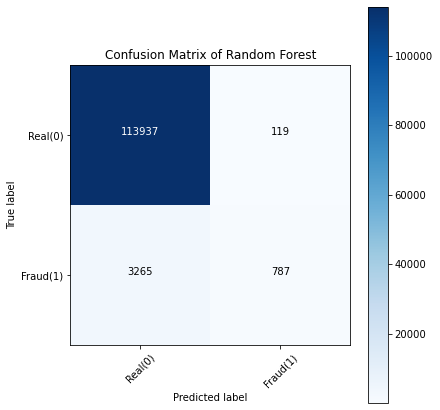

In [333]:
# Compute confusion matrix for the model

rf_matrix_selected_depth = confusion_matrix(yTest_comp, RF_pred_selected_depth, labels = [0, 1]) # Random Forest algorithm

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

rf_cm_plot_selected_depth = plot_confusion_matrix(rf_matrix_selected_depth, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Random Forest')
plt.show()

I will be working on hypertuning the Random Forest model using different set of parameters to further improve model performance

In [305]:
# perform grid search CV to find best parameter for the RandomForestClassfier model

param_grid = {
 'max_depth':[8,16], 
 'min_samples_split':[20,40],
 'min_samples_leaf': [4,8]  
}
gridSearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, n_jobs=1)
gridSearch.fit(xTrain_selected, yTrain_comp)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

Best score:  0.9751265803305256
Best parameters:  {'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 20}


In [322]:
pd.set_option('display.max_columns', None)

In [323]:
xTrain_selected.head(5)

,TransactionDT,card5,card1,addr2,C12,C13,C1,C10,C3,card3,D10,C7,V86,V85,C14,C9,C5,C11,V306,D1,C6,P_emaildomain_summary_aol_com,V309,V307,Transaction_Amount_bucket_low,V126,V282,V316,C8,card2
216944,5069957.0,226.0,13809.0,87.0,0.0,1.0,2.0,0.0,0.0,150.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,440.950012,0.0,2.0,0.0,0.0,440.950012,0.0,0.0,2.0,0.0,0.0,583.0
558411,14773564.0,226.0,12695.0,87.0,0.0,40.0,2.0,0.0,0.0,150.0,190.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.000000,102.0,1.0,0.0,0.0,2509.000000,0.0,0.0,0.0,0.0,0.0,490.0
369611,9207277.0,226.0,12695.0,87.0,0.0,8.0,2.0,0.0,0.0,150.0,12.0,0.0,1.0,0.0,2.0,3.0,0.0,1.0,117.000000,12.0,2.0,0.0,0.0,1031.000000,0.0,234.0,5.0,117.0,0.0,490.0
177738,3874678.0,117.0,18132.0,87.0,0.0,601.0,137.0,0.0,0.0,150.0,54.0,0.0,1.0,0.0,102.0,93.0,208.0,94.0,0.000000,130.0,92.0,0.0,0.0,165.899994,0.0,0.0,0.0,0.0,0.0,567.0
259974,6225517.0,224.0,17399.0,87.0,0.0,1.0,1.0,0.0,0.0,150.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,111.0


In [306]:
# Build and Train Random Forest model using parameters output from hyperparameter tuning

RF_clf_hypertuning = RandomForestClassifier(max_depth =16, min_samples_leaf =4, min_samples_split =20)

RF_clf_hypertuning.fit(xTrain_selected, yTrain_comp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=4,
                       min_samples_split=20, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [307]:
# Generate model performance on testing (validation) dataset using hypertuning parameters

RF_pred_hypertuning,RF_prob_hypertuning = RF_clf_hypertuning.predict(xTest_selected),RF_clf_hypertuning.predict_proba(xTest_selected)


In [308]:
print("Random Forest model scores on test dataset after applying hyperparameters : \n")

print_scores(yTest_comp,RF_pred_hypertuning,RF_prob_hypertuning)

Random Forest model scores on test dataset after applying hyperparameters : 

accuracy_score :  0.9762082162088935
precision_score :  0.9027237354085603
recall_score :  0.3435340572556762
f1 score :  0.49767608151591
AUC score :  0.6074651370740964
ROC_AUC score :  0.9042742945032249


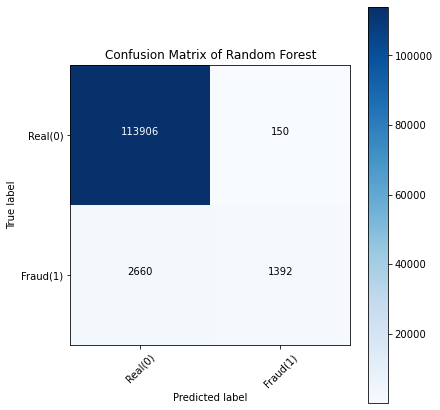

In [336]:
# Compute confusion matrix for the model

rf_matrix_hypertuning = confusion_matrix(yTest_comp, RF_pred_hypertuning, labels = [0, 1]) # Random Forest algorithm

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

rf_cm_plot_hypertuning = plot_confusion_matrix(rf_matrix_hypertuning, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'Random Forest')
plt.show()

In [312]:
# Here I am finding that after appying hyperparameers the F1 score of model went down hence I will be going with 
# model where F1 score for Random Forest is best after using 30 important features selected in previous section.

# Save the model with joblib library

joblib.dump(RF_clf_selected, 'credit_card_fraud_detection_model_rf.sav')

['credit_card_fraud_detection_model_rf.sav']

In [316]:
# loading the model to predict the outcome

filename = 'credit_card_fraud_detection_model_rf.sav'

model = joblib.load(filename)

In [319]:
# performing prediction manually to check if model is able to take input and generate the output successfully 
# before deploying it through web application

pred = model.predict(np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1]]))
print(pred)

[0.]


In [337]:
joblib.dump(RF_clf_selected_depth, 'credit_card_fraud_detection_model_rf_selected_depth.sav')

['credit_card_fraud_detection_model_rf_selected_depth.sav']

In [338]:
# loading the model to predict the outcome

filename = 'credit_card_fraud_detection_model_rf_selected_depth.sav'

model_selected_depth = joblib.load(filename)

In [341]:
# performing prediction manually to check if model is able to take input and generate the output successfully 
# before deploying it through web application

pred = model_selected_depth.predict(np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1]]))
print(pred)

[0.]


Here I will be deploying the model with Selected Depth for web application and the reason is that Random Forest model generates large size model and Heroku provides 512 MB memory for free tier and application with full size of Random Forest model needs 744 MB memory and hence application was failing.

# Working with DNN Model

In [92]:
# Apply DNN algorithm with multiple layers on the source dataset after oversampling was performed in training dataset
# and validate the model performance

# Here I am building a 5 layered neural network where I am using 4 dense layers and 1 dropout layer with threshold 0.5.


DNN_model = keras.Sequential([
layers.Dense(input_dim = 47,units= 47, activation = 'relu'),
layers.Dense(units = 24,activation = 'relu'),
layers.Dropout(0.5),
layers.Dense(units = 16,activation = 'relu'),
layers.Dense(units =1, activation = 'sigmoid'),])


In [93]:
DNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 47)                2256      
                                                                 
 dense_9 (Dense)             (None, 24)                1152      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                400       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,825
Trainable params: 3,825
Non-trainable params: 0
_________________________________________________________________


In [94]:
# I and using optimizer as adam and loss as binary_crossentropy because it is an classification problem specifically 2 
# Binary classification problem

DNN_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
DNN_model.fit(X_resample, y_resample.values.ravel(), batch_size = 16, epochs = 5)

Epoch 1/5
39885/39885 [==============================] - 56s 1ms/step - loss: 0.4157 - accuracy: 0.8140
Epoch 2/5
39885/39885 [==============================] - 51s 1ms/step - loss: 0.3774 - accuracy: 0.8356
Epoch 3/5
39885/39885 [==============================] - 50s 1ms/step - loss: 0.3616 - accuracy: 0.8430 0s -
Epoch 4/5
39885/39885 [==============================] - 51s 1ms/step - loss: 0.3530 - accuracy: 0.8475
Epoch 5/5
39885/39885 [==============================] - 53s 1ms/step - loss: 0.3464 - accuracy: 0.8506


In [115]:
# Different metrics on model performance using test dataset

Dnn_prob= DNN_model.predict(xTest)

# I am considering threshold as 0.5 to determine if transaction should be considered as Real or Fraud.

threshold =0.5
Dnn_preds=np.where(Dnn_prob > threshold, 1,0)

print("DNN model scores on test dataset : \n")

DNN_precision,DNN_recall,_ = precision_recall_curve(yTest,Dnn_prob)

scores.update({'DNN' : {
        'accuracy_score' : accuracy_score(yTest,Dnn_preds.round()),
        'precision_score' : precision_score(yTest,Dnn_preds.round()),
        'recall_score' : recall_score(yTest,Dnn_preds.round()),
        'f1_score' : f1_score(yTest,Dnn_preds.round()),
        'AUC_score': auc(DNN_recall,DNN_precision),
        'ROC_AUC_score': roc_auc_score(yTest, Dnn_prob)
    }})

scores['DNN']

DNN model scores on test dataset : 



{'accuracy_score': 0.9359738544383107,
 'precision_score': 0.281226626776365,
 'recall_score': 0.5567620927936822,
 'f1_score': 0.3736955441444426,
 'AUC_score': 0.4269322805958389,
 'ROC_AUC_score': 0.8709883938223728}

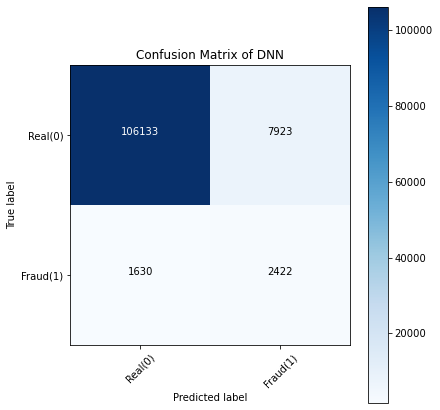

In [194]:
# Compute confusion matrix for the initial model

dnn_matrix = confusion_matrix(yTest, Dnn_preds, labels = [0, 1]) # DNN

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

dnn_cm_plot = plot_confusion_matrix(dnn_matrix, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'DNN')
plt.show()


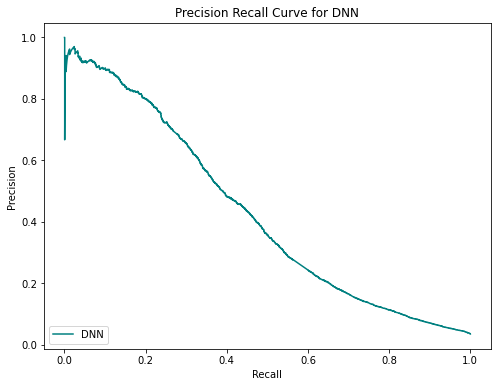

In [116]:
plt.figure(figsize=(8,6))
plt.plot(DNN_recall, DNN_precision, label='DNN',color='teal')
plt.title('Precision Recall Curve for DNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()


Performing hypertuning on DNN model

In [138]:
# I will be using below parameters to validate model and exteact the performance metrics to see if changing paramters are 
# helping in improving the model performance. I was finding that running these hyperparameters for DNN model through
# gridsearchCV was getting stuck and hence I decided executing it directly using few options here.

batches = [64, 256]
epochs = [3, 6]

# I am choosing input_dim as 47 here as I have 47 features in input dataset

def DNN_model_hypertuning_execution(input_batch_size,input_epochs):
    DNN_model_hyperparameter_tuning = keras.Sequential([
    layers.Dense(input_dim = 47,units= 47, activation = 'relu'),
    layers.Dense(units = 24,activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(units = 16,activation = 'relu'),
    layers.Dense(units =1, activation = 'sigmoid'),])

    DNN_model_hyperparameter_tuning.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    DNN_model_hyperparameter_tuning.fit(X_resample, y_resample.values.ravel(), batch_size = input_batch_size, epochs = input_epochs)

    Dnn_prob= DNN_model_hyperparameter_tuning.predict(xTest)

    threshold =0.5
    Dnn_preds=np.where(Dnn_prob > threshold, 1,0)

    print(f"DNN model scores on test dataset for batch_size {input_batch_size} and # of epochs {input_epochs} : ")

    DNN_precision,DNN_recall,_ = precision_recall_curve(yTest,Dnn_prob)

    scores.update({'DNN' : {
            'accuracy_score' : accuracy_score(yTest,Dnn_preds.round()),
            'precision_score' : precision_score(yTest,Dnn_preds.round()),
            'recall_score' : recall_score(yTest,Dnn_preds.round()),
            'f1_score' : f1_score(yTest,Dnn_preds.round()),
            'AUC_score': auc(DNN_recall,DNN_precision),
            'ROC_AUC_score': roc_auc_score(yTest, Dnn_prob)
        }})

    print(scores['DNN'])



In [141]:
DNN_model_hypertuning_execution(64,3)

Epoch 1/3
9972/9972 [==============================] - 15s 1ms/step - loss: 0.4265 - accuracy: 0.8093
Epoch 2/3
9972/9972 [==============================] - 14s 1ms/step - loss: 0.3835 - accuracy: 0.8343
Epoch 3/3
9972/9972 [==============================] - 14s 1ms/step - loss: 0.3668 - accuracy: 0.8428
DNN model scores on test dataset for batch_size 64 and # of epochs 3 : 
{'accuracy_score': 0.9243235005249433, 'precision_score': 0.24604989604989605, 'recall_score': 0.5841559723593287, 'f1_score': 0.34625511995318903, 'AUC_score': 0.420403592176967, 'ROC_AUC_score': 0.866986863270643}


In [142]:
DNN_model_hypertuning_execution(64,6)

Epoch 1/6
9972/9972 [==============================] - 15s 1ms/step - loss: 0.4239 - accuracy: 0.8095
Epoch 2/6
9972/9972 [==============================] - 13s 1ms/step - loss: 0.3827 - accuracy: 0.8338
Epoch 3/6
9972/9972 [==============================] - 13s 1ms/step - loss: 0.3674 - accuracy: 0.8423
Epoch 4/6
9972/9972 [==============================] - 13s 1ms/step - loss: 0.3583 - accuracy: 0.8473
Epoch 5/6
9972/9972 [==============================] - 15s 2ms/step - loss: 0.3515 - accuracy: 0.8509
Epoch 6/6
9972/9972 [==============================] - 14s 1ms/step - loss: 0.3466 - accuracy: 0.8529
DNN model scores on test dataset for batch_size 64 and # of epochs 6 : 
{'accuracy_score': 0.9131557557489756, 'precision_score': 0.2243937105800835, 'recall_score': 0.623395853899309, 'f1_score': 0.33000195963158924, 'AUC_score': 0.43352458790728027, 'ROC_AUC_score': 0.8678082631738857}


In [143]:
DNN_model_hypertuning_execution(256,3)

Epoch 1/3
2493/2493 [==============================] - 7s 2ms/step - loss: 0.4457 - accuracy: 0.7951
Epoch 2/3
2493/2493 [==============================] - 4s 2ms/step - loss: 0.4004 - accuracy: 0.8233
Epoch 3/3
2493/2493 [==============================] - 4s 2ms/step - loss: 0.3828 - accuracy: 0.8325
DNN model scores on test dataset for batch_size 256 and # of epochs 3 : 
{'accuracy_score': 0.9286923832424561, 'precision_score': 0.2542182227221597, 'recall_score': 0.5577492596248766, 'f1_score': 0.3492505022407665, 'AUC_score': 0.4121096806206901, 'ROC_AUC_score': 0.8681648005506863}


In [144]:
DNN_model_hypertuning_execution(256,6)

Epoch 1/6
2493/2493 [==============================] - 5s 2ms/step - loss: 0.4456 - accuracy: 0.7969
Epoch 2/6
2493/2493 [==============================] - 4s 2ms/step - loss: 0.3975 - accuracy: 0.8265
Epoch 3/6
2493/2493 [==============================] - 4s 2ms/step - loss: 0.3781 - accuracy: 0.8363
Epoch 4/6
2493/2493 [==============================] - 4s 2ms/step - loss: 0.3674 - accuracy: 0.8411
Epoch 5/6
2493/2493 [==============================] - 4s 2ms/step - loss: 0.3600 - accuracy: 0.8444
Epoch 6/6
2493/2493 [==============================] - 4s 2ms/step - loss: 0.3546 - accuracy: 0.8464
DNN model scores on test dataset for batch_size 256 and # of epochs 6 : 
{'accuracy_score': 0.9160768110542893, 'precision_score': 0.2302025782688766, 'recall_score': 0.6169792694965449, 'f1_score': 0.33530042918454933, 'AUC_score': 0.43576104482113537, 'ROC_AUC_score': 0.8752751480005907}


In [145]:
# Best hyperparameter for DNN model based on metrics output above:

batches = 256
epochs = 3

DNN_model_hyperparameter_tuning = keras.Sequential([
layers.Dense(input_dim = 47,units= 47, activation = 'relu'),
layers.Dense(units = 24,activation = 'relu'),
layers.Dropout(0.5),
layers.Dense(units = 16,activation = 'relu'),
layers.Dense(units =1, activation = 'sigmoid'),])

DNN_model_hyperparameter_tuning.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
DNN_model_hyperparameter_tuning.fit(X_resample, y_resample.values.ravel(), batch_size = 256, epochs = 3)

Dnn_prob= DNN_model_hyperparameter_tuning.predict(xTest)

threshold =0.5
Dnn_preds=np.where(Dnn_prob > threshold, 1,0)

print("DNN model scores on test dataset for batch_size 64 and # of epochs 3 : \n")

DNN_precision,DNN_recall,_ = precision_recall_curve(yTest,Dnn_prob)

scores.update({'DNN' : {
        'accuracy_score' : accuracy_score(yTest,Dnn_preds.round()),
        'precision_score' : precision_score(yTest,Dnn_preds.round()),
        'recall_score' : recall_score(yTest,Dnn_preds.round()),
        'f1_score' : f1_score(yTest,Dnn_preds.round()),
        'AUC_score': auc(DNN_recall,DNN_precision),
        'ROC_AUC_score': roc_auc_score(yTest, Dnn_prob)
    }})

scores['DNN']



Epoch 1/3
2493/2493 [==============================] - 5s 2ms/step - loss: 0.4401 - accuracy: 0.8006
Epoch 2/3
2493/2493 [==============================] - 6s 2ms/step - loss: 0.3933 - accuracy: 0.8291
Epoch 3/3
2493/2493 [==============================] - 6s 2ms/step - loss: 0.3758 - accuracy: 0.8382
DNN model scores on test dataset for batch_size 64 and # of epochs 3 : 



{'accuracy_score': 0.91911640193721,
 'precision_score': 0.23412276462058965,
 'recall_score': 0.5977295162882527,
 'f1_score': 0.3364589845106619,
 'AUC_score': 0.4095239127315907,
 'ROC_AUC_score': 0.8659542625395703}

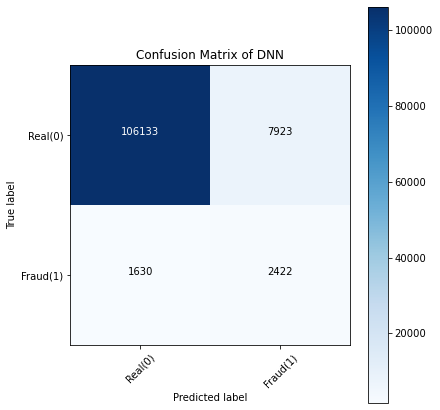

In [195]:
# Compute confusion matrix for the model using the best hyperparameters

dnn_matrix_after_hypertuning = confusion_matrix(yTest, Dnn_preds, labels = [0, 1]) # DNN

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

dnn_cm_plot = plot_confusion_matrix(dnn_matrix_after_hypertuning, 
                                classes = ['Real(0)','Fraud(1)'], 
                                normalize = False, title = 'DNN')
plt.show()


Metrics output from best 4 ML models --> One each for Logistic Regression algorithm, Decision Tree algorithm, Random Forest algorithm and
DNN (Deep Neural Network)

# Logistic Regression Model:

accuracy_score :  0.9171774985606395

precision_score :  0.18878991961764066

recall_score :  0.428923988153998

f1 score :  0.2621813244833308

AUC score :  0.2344248026372859

ROC_AUC score :  0.8123184353388415


# Decision Tree Model:

accuracy_score :  0.9755478037050835

precision_score :  0.7779369627507163

recall_score :  0.40202369200394866

f1 score :  0.5301008786202408

AUC score :  0.5298767163839708

ROC_AUC score :  0.849328252947358

# Random Forest Model:

accuracy_score :  0.9794510109391404

precision_score :  0.8584031760035289

recall_score :  0.48025666337611056

f1 score :  0.61592024054439

AUC score :  0.695418139541437

ROC_AUC score :  0.9103091778888202

# DNN Model:

accuracy_score: 0.91911640193721,

precision_score: 0.23412276462058965,
 
recall_score: 0.5977295162882527,

f1_score: 0.3364589845106619,
 
AUC_score: 0.4095239127315907,
 
ROC_AUC_score: 0.8659542625395703

# Conclusion:

I worked on extracing performance for all 4 models created using below algorithms:

1. Logistic Regression
2. Decision Tree
3. Random Forest
4. DNN (Deep Neural Network)

Performed hypertuning on model created using Decision Tree and Random Forest algorithms as I found these 2 algorithms have better output scores.

Based on output shared above, Finally I found model using Random Forest algorithms have best performance among all 4 models.

I have deployed Random Forest model on Heroku to a web application for predicting the outcome base don input features provided.

Web application link: https://creditcard-fraud-detection-sk.herokuapp.com/

Github repository for code: https://github.com/saurav2k1/credit-card-fraud-detection-sk